In [1]:
try:
  %tensorflow_version 2.x  # Colab only.
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

`%tensorflow_version` only switches the major version: `1.x` or `2.x`.
You set: `2.x  # Colab only.`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.
2.1.0


In [0]:
import numpy as np
import matplotlib.pyplot as plt

In [0]:
from tensorflow.keras.datasets.mnist import load_data
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [4]:
dataset = load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
type(dataset)

tuple

In [0]:
(X_train, y_train), (X_test, y_test) = dataset
# X_train.shape             (60000, 28, 28)
# y_train.shape             (60000,)
# X_test.shape              (10000, 28, 28)
# y_test.shape              (10000,)

In [0]:
# It is also recommended that real images used to train the discriminator are scaled so that their pixel values 
# are in the range [-1,1]. This is so that the discriminator will always receive images as input, real and fake, 
# that have pixel values in the same range.
X_train = (X_train - 127.5) / 127.5
X_test = (X_test - 127.5) / 127.5

In [0]:
# Flatten the data
H, W = X_train.shape[1:]               # (28, 28)
D = H * W                              # 784
X_train = X_train.reshape(-1, D)       # (60000, 784)
X_test = X_test.reshape(-1, D)         # (10000, 784)

In [0]:
# Dimensionality of the latent space
DIM = 100

In [0]:
batch_size = 32

steps_per_epoch = X_train.shape[0] // batch_size         # 60000 // 32
# print(steps_per_epoch)                                 # 1875

ones = np.ones(batch_size)                               # (32,)
zeros = np.zeros(batch_size)                             # (32,)

In [11]:
# Generator will take the input from latent space which is of the size 100 and output an image of size 784. This will be fed into a Discriminator.
def make_generator_model(noise):
  i = Input(shape=(noise))
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(i)
  x = BatchNormalization()(x)
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization()(x)
  x = Dense(1024, activation=LeakyReLU(alpha=0.2))(x)
  x = BatchNormalization()(x)
  x = Dense(D, activation='tanh')(x)

  model = Model(i, x)
  return model

generator = make_generator_model(DIM)
generator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 256)               25856     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              525312    
_________________________________________________________________
batch_normalization_2 (Batch (None, 1024)              4096  

In [12]:
# Discriminator will take the input from real data which is of the size 784 and also the images of size 784 generated from Generator.
def make_discriminator_model(D):
  i = Input(shape=(D))
  x = Dense(512, activation=LeakyReLU(alpha=0.2))(i)
  x = Dense(256, activation=LeakyReLU(alpha=0.2))(x)
  x = Dense(1, activation='sigmoid')(x)

  model = Model(i, x)
  return model

discriminator = make_discriminator_model(D)
discriminator.compile(
    loss='binary_crossentropy',
    optimizer=Adam(0.0002, 0.5),
    metrics=['accuracy']
)

discriminator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
_________________________________________________________________


In [13]:
# We now create the GAN where we combine the Generator and Discriminator. 
# When we train the Generator we will freeze the Discriminator.
# We will input the noised image of shape 100 units to the Generator. The output generated from the Generator will be fed to the Discriminator.

# Create an input to represent noise sample from latent space
gan_input = Input(shape=(DIM,))                                # (None, 100)
# Pass noise through generator to get an image
image = generator(gan_input)                                   # (None, 784)
# Make sure only the generator is trained
discriminator.trainable = False
# Pass this image through discriminator to get a fake image
fake_image = discriminator(image)                              # (None, 1)
# Create the combined model object
gan = Model(gan_input, fake_image)
gan.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
gan.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
model (Model)                (None, 784)               1493520   
_________________________________________________________________
model_1 (Model)              (None, 1)                 533505    
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [0]:
def plot_generated_images(epoch):
  noise = np.random.randn(25, DIM)                             # (25, 100)
  generated_images = generator.predict(noise)                  # (25, 784)
  generated_images = generated_images.reshape(25,28,28)        # (25, 28, 28)
  fig, axes = plt.subplots(5, 5, figsize=(20,20))              # We use 5 rows & 5 columns as there are 25 images
  axes = axes.flatten()
  for img, ax in zip(generated_images, axes):
    ax.imshow(img)
    plt.axis('off')
  plt.tight_layout()
  plt.savefig('gan_generated_image %d.png' %epoch)
  plt.close()

In [17]:
sample_period = 200

epochs = 20000

for epoch in range(epochs):

  ############################
  # TRAINING THE DISCRIMINATOR
  ############################

  # select random real images
  random_index = np.random.randint(0, len(X_train) - 1, batch_size)  # Take 32 random numbers from 0 to 59999 -> (32,)
  real_images = X_train[random_index]                                # (32, 784)

  # select fake images
  noise = np.random.rand(batch_size, DIM)                            # (32, 100)
  fake_images = generator.predict(noise)                             # (32, 784)

  disc_loss_real, disc_acc_real = discriminator.train_on_batch(real_images, ones)
  disc_loss_fake, disc_acc_fake = discriminator.train_on_batch(fake_images, zeros)
  discriminator_loss = (disc_loss_real + disc_loss_fake) / 2
  discriminator_acc  = (disc_acc_real + disc_acc_fake) / 2

  ########################
  # TRAINING THE GENERATOR
  ########################

  noise = np.random.rand(batch_size, DIM)                            # (32, 100)
  gen_loss = gan.train_on_batch(noise, ones)

  if epoch % 100 == 0:
    print(f"epoch: {epoch}/{epochs}, discriminator_loss: {discriminator_loss:.2f}, discriminator_acc: {discriminator_acc:.2f}, generator_loss: {gen_loss:.2f}")

  if epoch % sample_period == 0:
    plot_generated_images(epoch)

epoch: 0/20000, discriminator_loss: 0.34, discriminator_acc: 1.00, generator_loss: 0.70
epoch: 100/20000, discriminator_loss: 0.02, discriminator_acc: 1.00, generator_loss: 2.65
epoch: 200/20000, discriminator_loss: 0.03, discriminator_acc: 1.00, generator_loss: 10.86
epoch: 300/20000, discriminator_loss: 0.08, discriminator_acc: 1.00, generator_loss: 7.41
epoch: 400/20000, discriminator_loss: 0.08, discriminator_acc: 1.00, generator_loss: 5.78
epoch: 500/20000, discriminator_loss: 0.31, discriminator_acc: 0.84, generator_loss: 3.50
epoch: 600/20000, discriminator_loss: 0.64, discriminator_acc: 0.62, generator_loss: 1.89
epoch: 700/20000, discriminator_loss: 0.68, discriminator_acc: 0.50, generator_loss: 0.84
epoch: 800/20000, discriminator_loss: 0.69, discriminator_acc: 0.47, generator_loss: 0.79
epoch: 900/20000, discriminator_loss: 0.66, discriminator_acc: 0.55, generator_loss: 0.77
epoch: 1000/20000, discriminator_loss: 0.59, discriminator_acc: 0.70, generator_loss: 0.89
epoch: 110

In [18]:
!ls

'gan_generated_image 0.png'	 'gan_generated_image 19000.png'
'gan_generated_image 10000.png'  'gan_generated_image 19200.png'
'gan_generated_image 1000.png'	 'gan_generated_image 19400.png'
'gan_generated_image 10200.png'  'gan_generated_image 19600.png'
'gan_generated_image 10400.png'  'gan_generated_image 19800.png'
'gan_generated_image 10600.png'  'gan_generated_image 2000.png'
'gan_generated_image 10800.png'  'gan_generated_image 200.png'
'gan_generated_image 11000.png'  'gan_generated_image 2200.png'
'gan_generated_image 11200.png'  'gan_generated_image 2400.png'
'gan_generated_image 11400.png'  'gan_generated_image 2600.png'
'gan_generated_image 11600.png'  'gan_generated_image 2800.png'
'gan_generated_image 11800.png'  'gan_generated_image 3000.png'
'gan_generated_image 12000.png'  'gan_generated_image 3200.png'
'gan_generated_image 1200.png'	 'gan_generated_image 3400.png'
'gan_generated_image 12200.png'  'gan_generated_image 3600.png'
'gan_generated_image 12400.png'  'gan_gene

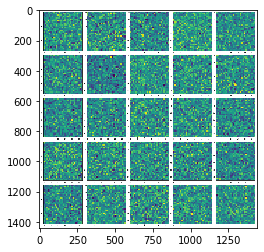

In [19]:
import matplotlib.image as mpimg
image = mpimg.imread('gan_generated_image 0.png')
plt.imshow(image)

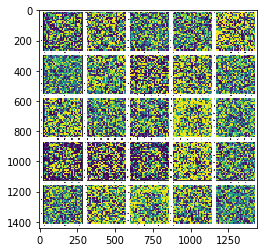

In [21]:
import matplotlib.image as mpimg
image = mpimg.imread('gan_generated_image 200.png')
plt.imshow(image)

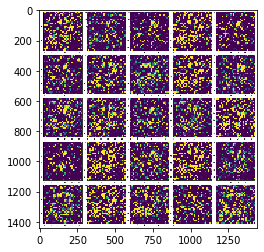

In [23]:
import matplotlib.image as mpimg
image = mpimg.imread('gan_generated_image 600.png')
plt.imshow(image)

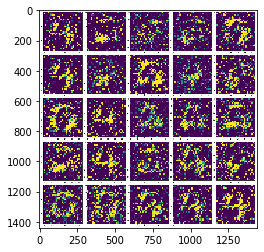

In [24]:
import matplotlib.image as mpimg
image = mpimg.imread('gan_generated_image 1000.png')
plt.imshow(image)

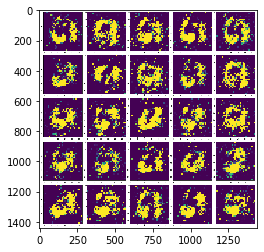

In [25]:
import matplotlib.image as mpimg
image = mpimg.imread('gan_generated_image 2000.png')
plt.imshow(image)

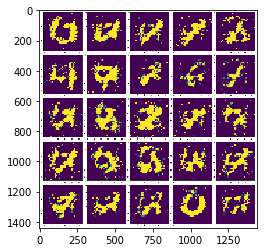

In [26]:
import matplotlib.image as mpimg
image = mpimg.imread('gan_generated_image 5000.png')
plt.imshow(image)

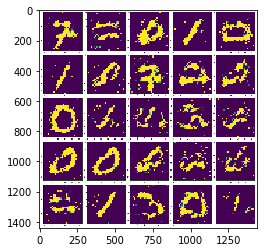

In [27]:
import matplotlib.image as mpimg
image = mpimg.imread('gan_generated_image 15000.png')
plt.imshow(image)

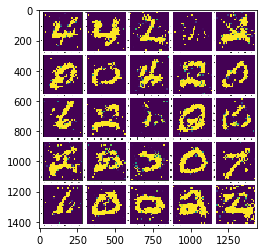

In [28]:
import matplotlib.image as mpimg
image = mpimg.imread('gan_generated_image 19000.png')
plt.imshow(image)